## Use TPU

In [ ]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
# hugging face transformers 라이브러리 설치
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 120 kB 63.3 MB/s 
     |████████████████████████████████| 6.6 MB 60.4 MB/s 


## Import library

In [ ]:
import os

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm.notebook import tqdm
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## Download the data

In [ ]:
!gdown 1NmSV5Oaa2UIrSloWEQGgNvRyBRIDYNdA

Downloading...
From: https://drive.google.com/uc?id=1NmSV5Oaa2UIrSloWEQGgNvRyBRIDYNdA
To: /content/kaggledata.pkl
100% 68.6M/68.6M [00:00<00:00, 263MB/s]


In [ ]:
import pickle

with open('/content/kaggledata.pkl', 'rb') as f:
  dataset = pickle.load(f)

In [ ]:
dataset

,type,posts,I,N,F,P
0,INFJ,enfp and intj moments sportscenter not t...,1,1,1,0
1,ENTP,im finding the lack of me in these pos...,0,1,0,1
2,INTP,good one of course to which i say i ...,1,1,0,1
3,INTJ,dear intp i enjoyed our conversation the...,1,1,0,0
4,ENTJ,youre fired thats another silly misconcep...,0,1,0,0
...,...,...,...,...,...,...
8670,ISFP,ixfp just because i always think of cat...,1,0,1,1
8671,ENFP,soif this thread already exists someplace...,0,1,1,1
8672,INTP,so many questions when i do these thing...,1,1,0,1
8673,INFP,i am very conflicted right now when it ...,1,1,1,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
 2   I       8675 non-null   int64 
 3   N       8675 non-null   int64 
 4   F       8675 non-null   int64 
 5   P       8675 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 406.8+ KB


In [ ]:
dataset.dtypes

type     object
posts    object
I         int64
N         int64
F         int64
P         int64
dtype: object

In [ ]:
# 결측치 제거
dataset.dropna(inplace=True)

In [ ]:
dataset['N']=pd.to_numeric(dataset['N'])

In [ ]:
dataset['N'].nunique()

2

In [ ]:
dataset['N'].value_counts()

1    7478
0    1197
Name: N, dtype: int64

## Encoding Tokenizer

- 한국어 BERT :  https://huggingface.co/snunlp/KR-BERT-char16424

- Fast Tokenizer : https://huggingface.co/docs/transformers/main_classes/tokenizer

In [ ]:
# hugging face transformers 설치
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# 인코딩 전 test data의 결측치 제거 
data = dataset.dropna()
print(len(data))

8675


In [ ]:
data=dataset['posts']
target=dataset['N']

In [ ]:
data

0       enfp  and  intj  moments  sportscenter  not  t...
1       im  finding  the  lack  of  me  in  these  pos...
2       good  one    of  course  to  which  i  say  i ...
3       dear  intp  i  enjoyed  our  conversation  the...
4       youre  fired  thats  another  silly  misconcep...
                              ...                        
8670    ixfp  just  because  i  always  think  of  cat...
8671    soif  this  thread  already  exists  someplace...
8672    so  many  questions  when  i  do  these  thing...
8673    i  am  very  conflicted  right  now  when  it ...
8674    it  has  been  too  long  since  i  have  been...
Name: posts, Length: 8675, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=34)

In [ ]:
X_train_list= X_train.tolist()
X_test_list = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [ ]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)# truncation : 최대문장 길이에 맞춰서 조정해줌
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [ ]:
print(X_train[12].tokens)

['[CLS]', '3', 'reminds', 'me', 'of', 'myself', 'when', 'i', 'was', 'younger', 'that', '##s', 'right', 'i', 'mature', '##d', 'into', 'a', 'human', 'lo', '##l', 'i', 'like', 'that', 'one', 'the', 'only', 'times', 'i', 'really', 'mind', 'people', 'dismissing', 'my', 'conclusions', 'is', 'when', 'iv', '##e', 'put', 'in', 'considerable', 'energy', 'to', 'explain', 'myself', 'and', 'when', 'it', 'becomes', 'clear', 'that', 'the', 'person', 'was', 'never', 'really', 'interested', 'in', 'a', 'good', 'to', 'see', 'this', 'place', 'hasn', '##t', 'changed', 'much', 'okay', 'here', 'is', 'my', 'own', 'un', '##pro', '##fe', '##ssion', '##al', 'opinion', 'it', 'sounds', 'like', 'you', 'are', 'not', 'communicating', 'your', 'needs', 'well', 'enough', 'or', 'that', 'he', 'for', 'some', 'reason', 'can', '##t', 'or', 'refuses', 'to', 'understand', 'one', 'you', 'can', 'do', 'something', 'about', 'funeral', '##s', 'are', 'not', 'for', 'the', 'persons', 'who', 'died', 'but', 'the', 'ones', 'living', 'gr'

In [ ]:
print(X_train[0].ids)

[101, 2196, 2568, 2115, 4167, 2987, 2102, 2412, 2689, 2049, 3722, 11265, 10976, 6483, 2115, 6180, 2003, 2115, 3265, 3670, 1997, 2040, 2017, 2024, 1998, 2748, 2008, 2064, 2689, 19059, 2084, 1996, 4633, 2049, 1037, 2307, 2111, 2008, 2228, 2037, 2828, 3431, 2412, 2153, 1045, 2064, 2102, 24964, 14621, 2618, 2023, 2438, 2049, 1037, 3143, 24216, 1997, 11810, 2937, 2828, 3399, 2008, 3463, 1999, 1996, 3314, 2017, 2716, 2039, 2017, 2052, 2022, 4527, 2129, 2172, 11810, 2370, 3569, 1996, 14166, 2115, 22128, 2003, 2440, 1997, 2663, 2008, 2003, 2035, 7191, 13121, 21358, 16416, 6834, 3549, 2049, 2066, 2023, 2005, 2033, 2012, 2188, 2147, 4385, 5674, 1996, 3276, 2090, 1998, 20014, 10374, 2546, 3501, 1052, 2053, 2595, 5428, 2200, 5580, 2000, 2963, 2008, 2115, 3276, 2003, 1996, 5968, 10667, 23806, 2100, 8840, 2140, 2926, 6195, 1996, 4489, 1999, 29202, 2015, 1998, 12411, 16846, 2229, 2174, 1045, 2064, 2156, 2129, 2009, 2094, 2147, 1999, 2115, 2553, 1996, 27937, 13102, 3398, 1045, 5993, 1045, 2052, 2031, 

## Dataset


In [ ]:
import tensorflow as tf

# 주어진 데이터소스를 여러 Tensor로 자른 후 iterator(반복가능 객체)로 만들기
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [ ]:
example = val_dataset.take(1)
a = list(example.as_numpy_iterator())
a

[({'input_ids': array([  101,  1045,  5993,  2007, 17183,  6494,  2063,  1045,  3643,
           2026,  9394,  1998,  1996,  9379,  7224,  1997,  2026,  2188,
           1045,  2123,  2102,  2031,  2051,  2000,  2191,  2047,  2814,
           1998,  1045,  2123,  2102,  2342,  4902, 23105, 29409, 10047,
           2788,  5697,  2087,  1997,  6533,  1997,  2026,  7133,  3514,
           2006,  3536,  2324,  1060,  2484,  2355,  2659, 26358,  2669,
           2378,  1037, 14257,  4951,  5219,  1037, 23064, 20760,  2863,
           7822,  1999,  1996,  9733,  8894,  1037,  2931,  7118,  4256,
           1037,  4440,  2000,  7623,  1037, 27829,  2319,  5403,  2232,
           6602,  1037, 13433,  4168, 17643, 12556, 28432,  3165,  2606,
          23751,  2665,  2159,  3398,  1045,  2079,  2008,  2049,  1037,
           2126,  1997, 10863,  2026,  4301,  2077,  1037,  8312,  2030,
           4613,  1045,  2066,  2000,  8849,  2296,  2825, 11967,  2074,
           1999,  2553,  2049,  2036, 

#### tf.data 데이터셋 생성하기
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

In [ ]:
# Dataset.from_tensor_slice 예시
dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
list(dataset.as_numpy_iterator())

[array([1, 2], dtype=int32), array([3, 4], dtype=int32)]

In [ ]:
dataset = tf.data.Dataset.range(8)
dataset = dataset.batch(3)
list(dataset.as_numpy_iterator())

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]

- 자주 쓰는 tf.data.dataset 하위 메서드

    -  repeat(n) - Dataset n번 반복해서 하나로 붙힘

    - skip(n) - Dataset 반복자로 돌릴 때 n만큼 skip. n이 7이라면 1~10까지 돌리면 7까지 생략 후 8,9,10 나옴

    - batch(n) - Dataset을 n개의 batch로 쪼갬

    - shuffle(buffer_size, seed=None, reshuffle_each_iteration=None) : dataset을 섞기

## Model


- model source : https://github.com/huggingface/transformers/blob/v4.19.2/src/transformers/models/bert/modeling_tf_bert.py#L1605

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                              num_labels=2)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
model.summary() 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#loss = tf.keras.losses.BinaryCrossentropy(from_logits = True) #이진분류

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

with strategy.scope():
  model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                              num_labels=2)
  
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits = True) #이진분류
  

  callback_earlystop = EarlyStopping(
      monitor="val_loss", 
      min_delta=0.001,
      patience=3)

  model.fit(
      train_dataset.shuffle(1000).batch(16), epochs=20, batch_size=16,
      validation_data = val_dataset.shuffle(1000).batch(16),callbacks = [callback_earlystop])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/20
434/434 [==============================] - 88s 86ms/step - loss: 0.3621 - accuracy: 0.8650 - val_loss: 0.3383 - val_accuracy: 0.8784
Epoch 2/20
434/434 [==============================] - 30s 69ms/step - loss: 0.2902 - accuracy: 0.8843 - val_loss: 0.2769 - val_accuracy: 0.8888
Epoch 3/20
434/434 [==============================] - 30s 69ms/step - loss: 0.2129 - accuracy: 0.9189 - val_loss: 0.3409 - val_accuracy: 0.8813
Epoch 4/20
434/434 [==============================] - 30s 69ms/step - loss: 0.1203 - accuracy: 0.9566 - val_loss: 0.4927 - val_accuracy: 0.8738
Epoch 5/20
434/434 [==============================] - 30s 69ms/step - loss: 0.0528 - accuracy: 0.9847 - val_loss: 0.3912 - val_accuracy: 0.8692


In [ ]:
model.save_weights("distilbert-base-uncased_sn.h5")

## Test the model

In [ ]:
# output을 바로 뽑아주는 TextClassificationPipeline
from transformers import TextClassificationPipeline


text_classifier = TextClassificationPipeline(
    tokenizer=tokenizer, 
    model=model, 
    framework='tf',
    return_all_scores=True
)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [ ]:
X_test

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 라벨과 score 이 나온다I
text_classifier("Let’s think the unthinkable, let’s do the undoable. Let us prepare to grapple with the ineffable itself, and see if we may not eff it after all.")[0]

[{'label': 'LABEL_0', 'score': 0.04016119986772537},
 {'label': 'LABEL_1', 'score': 0.9598388075828552}]

In [ ]:
text_classifier("	You look pretty hot. I like!")

[[{'label': 'LABEL_0', 'score': 0.36508601903915405},
  {'label': 'LABEL_1', 'score': 0.634913980960846}]]

In [ ]:
text_classifier("Many personality.")[0]

[{'label': 'LABEL_0', 'score': 0.31974726915359497},
 {'label': 'LABEL_1', 'score': 0.6802526712417603}]

In [ ]:
text_classifier("I had a conversation with my roommate and I got so frustrated")[0]

[{'label': 'LABEL_0', 'score': 0.4225861728191376},
 {'label': 'LABEL_1', 'score': 0.57741379737854}]

In [ ]:
text_classifier("Let’s think the unthinkable, let’s do the undoable. Let us prepare to grapple with the ineffable itself, and see if we may not eff it after all.")[0]

[{'label': 'LABEL_0', 'score': 0.04016119986772537},
 {'label': 'LABEL_1', 'score': 0.9598388075828552}]

In [ ]:
text_classifier("I don’t really want to become normal, average, standard. I want merely to gain in strength, in the courage to live out my life more fully, enjoy more, experience more. I want to develop even more original and more unconventional traits")[0]


[{'label': 'LABEL_0', 'score': 0.25893309712409973},
 {'label': 'LABEL_1', 'score': 0.7410669326782227}]

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

#Predict
y_pred = model.predict(X_test['input_ids'])

In [ ]:
y_pred_arg = np.argmax(y_pred['logits'], axis=1)

In [ ]:
label = ['S', 'N']

In [ ]:
label = ['INFP', 'ISFP', 'INFJ', 'ISFJ', 'ENFP', 'ESFP', 'ENFJ', 'ESFJ', 'INTP', 'ISTP', 'INTJ', 'ISTJ', 'ENTP', 'ESTP', 'ENTJ', 'ESTJ']


In [ ]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_arg)

print(cf_matrix)

[[ 120  119]
 [ 117 1379]]


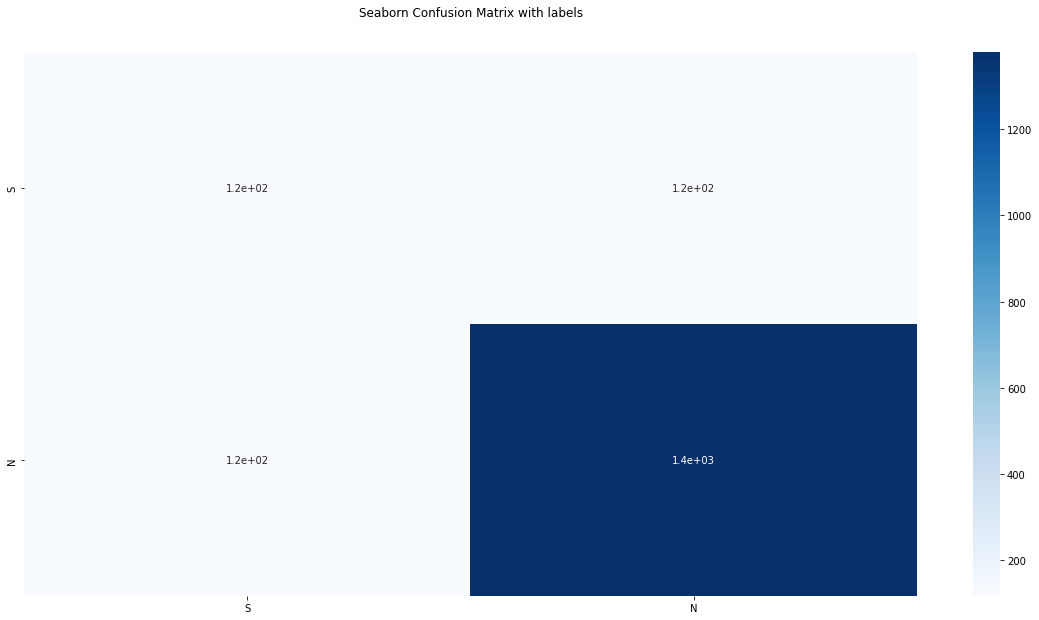

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
# ax.set_xlabel('\nPredicted Flower Category')
# ax.set_ylabel('Actual Flower Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label)
ax.yaxis.set_ticklabels(label)

## Display the visualization of the Confusion Matrix.
plt.show()

## Word cloud


In [ ]:
data   # data = dataset['posts']

0       enfp  and  intj  moments  sportscenter  not  t...
1       im  finding  the  lack  of  me  in  these  pos...
2       good  one    of  course  to  which  i  say  i ...
3       dear  intp  i  enjoyed  our  conversation  the...
4       youre  fired  thats  another  silly  misconcep...
                              ...                        
8670    ixfp  just  because  i  always  think  of  cat...
8671    soif  this  thread  already  exists  someplace...
8672    so  many  questions  when  i  do  these  thing...
8673    i  am  very  conflicted  right  now  when  it ...
8674    it  has  been  too  long  since  i  have  been...
Name: posts, Length: 8675, dtype: object

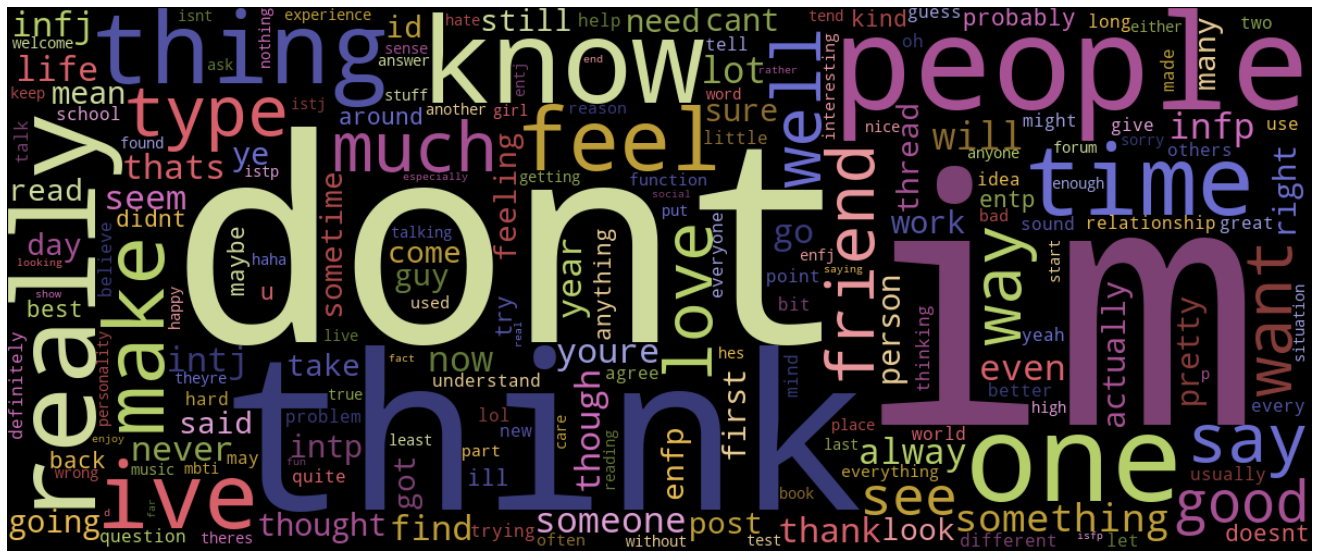

In [ ]:
#Wordcloud - see most common words used, after removing stopwords
from wordcloud import WordCloud, STOPWORDS
#stopwords = common english words that don't add significant value to prediction/analysis eg: I, was, who, some, why etc
import matplotlib.pyplot as plt

words = list(data.apply(lambda x: x.split()))
words = [x for y in words for x in y]

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords =stopwords, width=1200, height=500, 
                         collocations=False, background_color="black", 
                         colormap="tab20b").generate(" ".join(words))

# collocations = False so that wordcloud doesn't visualise words as duplicates
plt.figure(figsize=(25,10))
plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")